# Summary

Here we implemented a PySpark solution for large-scale data processing.

Datails are outlined as following:

- Process and transform data using PySpark DataFrame operations
- Implement efficient data partitioning strategies
- Create aggregations and statistical summaries
- Optimize performance using appropriate Spark Configurations
- Generate comprehensive data quality reports

Data source:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Coding environment:
Google colab, Python 3 + CPU

## packages and dependencies

In [1]:
!pip install kaggle

In [2]:
import os

# Create the .kaggle directory
os.makedirs('/root/.config/kaggle', exist_ok=True)

# Move kaggle.json to the .kaggle directory
!mv kaggle.json /root/.config/kaggle/

In [3]:
# security concern on API key
!chmod 600 /root/.config/kaggle/kaggle.json

In [4]:
import numpy as np
import pandas as pd

import kaggle

import zipfile

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

## dataset

In [5]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 77% 51.0M/66.0M [00:00<00:00, 143MB/s]
100% 66.0M/66.0M [00:00<00:00, 135MB/s]


In [6]:
with zipfile.ZipFile("creditcardfraud.zip", 'r') as zip_ref:
    # Extract to a folder named "data"
    zip_ref.extractall("data")

In [7]:
# tried this part tho fail on reach my GPU limitation

# # Create Spark session with RAPIDS GPU support
# spark = (
#     SparkSession.builder
#     .appName("Large-Scale Data")
#     .config("spark.rapids.sql.enabled", "true")
#     .config("spark.executor.resource.gpu.amount", "1")
#     .config("spark.task.resource.gpu.amount", "0.5")
#     .config("spark.sql.shuffle.partitions", "16")
#     .getOrCreate()
# )

# avaliable resources: 2 virtual CPUs and ~12GB of RAM
spark = (
    SparkSession.builder
    .appName("Large-Scale Data")
    .master("local[*]")  # Use all available CPU cores
    .config("spark.executor.memory", "8g")  # Assign 8GB to the executor
    .config("spark.driver.memory", "8g")    # Assign 8GB to the driver
    .config("spark.sql.shuffle.partitions", "16")  # Increase partitions for better parallelism
    .config("spark.default.parallelism", "16")     # Adjust to handle larger data loads
    .getOrCreate()
)

In [8]:
df = spark.read.csv("data/creditcard.csv", header=True, inferSchema=True)

## dataset description

The dataset contains transactions made by credit cards in September 2013 by European cardholders.

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount.

Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [9]:
# show the size of the data set

# Get the row count
row_count = df.count()

# Get the column count
column_count = len(df.columns)

# Print the results
print(f"Row Count: {row_count}")
print(f"Column Count: {column_count}")

Row Count: 284807
Column Count: 31


In [10]:
def calculate_completeness(df):
    # Calculate the total number of cells (rows * columns)
    total_cells = df.count() * len(df.columns)

    # Calculate the total number of non-null values in the dataset
    non_null_cells = df.select([F.count(F.when(F.col(c).isNotNull(), c)).alias(c) for c in df.columns])
    total_non_null_cells = non_null_cells.select([F.sum(c).alias(c) for c in non_null_cells.columns]).collect()[0]

    # Sum the non-null values across all columns
    total_non_null_values = sum([total_non_null_cells[c] for c in non_null_cells.columns])

    # Calculate completeness as the percentage of non-null values
    completeness = (total_non_null_values / total_cells) * 100

    return completeness

completeness = calculate_completeness(df)
print(f"Overall Completeness: {completeness:.2f}%")

Overall Completeness: 100.00%


## column level summaries

In [11]:
def column_level_summary(df):
    ''' function for column level summary'''

    # Initialize summary dictionary
    column_summary = {}

    # Loop through each column
    for column in df.columns:
        # Get data type of the column
        dtype = df.schema[column].dataType

        # Count unique values
        unique_values_count = df.select(column).distinct().count()

        # Count missing values
        missing_count = df.filter(df[column].isNull()).count()
        total_count = df.count()
        missing_percentage = (missing_count / total_count) * 100

        # Count empty/whitespace strings (for string columns)
        if dtype == 'string':
            empty_count = df.filter(df[column] == '').count()
        else:
            empty_count = 0

        # Most frequent value (mode)
        mode_value = df.groupBy(column).count().orderBy(F.desc('count')).first()
        mode_value = mode_value[column] if mode_value else None

        # Descriptive statistics for numeric columns
        if isinstance(dtype, (T.IntegerType, T.FloatType, T.DoubleType, T.LongType)):
            stats = df.describe(column).collect()
            min_value = stats[0][1] if stats else None
            max_value = stats[1][1] if stats else None
            mean_value = stats[2][1] if stats else None
            stddev_value = stats[3][1] if stats else None
            column_summary[column] = {
                "DataType": dtype,
                "UniqueValues": unique_values_count,
                "MissingValuesCount": missing_count,
                "MissingValuesPercentage": missing_percentage,
                "EmptyStringsCount": empty_count,
                "Mode": mode_value,
                "Min": min_value,
                "Max": max_value,
                "Mean": mean_value,
                "StandardDeviation": stddev_value
            }
        else:
            column_summary[column] = {
                "DataType": dtype,
                "UniqueValues": unique_values_count,
                "MissingValuesCount": missing_count,
                "MissingValuesPercentage": missing_percentage,
                "EmptyStringsCount": empty_count,
                "Mode": mode_value
            }

    return column_summary

In [12]:
summary = column_level_summary(df)

# Print the summary for each column
for column, stats in summary.items():
    print(f"Column: {column}")
    for stat, value in stats.items():
        print(f"  {stat}: {value}")

Column: Time
  DataType: DoubleType()
  UniqueValues: 124592
  MissingValuesCount: 0
  MissingValuesPercentage: 0.0
  EmptyStringsCount: 0
  Mode: 163152.0
  Min: 284807
  Max: 94813.85957508067
  Mean: 47488.145954566295
  StandardDeviation: 0.0
Column: V1
  DataType: DoubleType()
  UniqueValues: 275663
  MissingValuesCount: 0
  MissingValuesPercentage: 0.0
  EmptyStringsCount: 0
  Mode: 2.05579700630039
  Min: 284807
  Max: 9.12506051577434E-16
  Mean: 1.958695803857485
  StandardDeviation: -56.407509631329
Column: V2
  DataType: DoubleType()
  UniqueValues: 275663
  MissingValuesCount: 0
  MissingValuesPercentage: 0.0
  EmptyStringsCount: 0
  Mode: 0.166975019545401
  Min: 284807
  Max: 2.3151947065394213E-16
  Mean: 1.651308579476997
  StandardDeviation: -72.7157275629303
Column: V3
  DataType: DoubleType()
  UniqueValues: 275663
  MissingValuesCount: 0
  MissingValuesPercentage: 0.0
  EmptyStringsCount: 0
  Mode: -2.75204095570008
  Min: 284807
  Max: -1.3220560117342351E-15
  Mea

## dataset level summaries

In [13]:
# function to do summarization
def dataset_level_summary(df):
    ''' function for dataset level summary of a given df'''
    # Initialize summary dictionary
    summary = {}

    # Missing Data Overview
    total_rows = df.count()
    total_columns = len(df.columns)

    # Count of missing values per column
    missing_per_column = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
    missing_per_column = missing_per_column.collect()[0].asDict()

    missing_per_column_percentage = {
        column: (missing_per_column[column] / total_rows) * 100 for column in missing_per_column
    }

    # Percentage of rows with missing data (at least one column missing)
    rows_with_missing = df.filter(F.concat_ws('', *[F.col(c).cast("string") for c in df.columns]).isNull()).count()
    rows_with_missing_percentage = (rows_with_missing / total_rows) * 100

    # Duplicate Records
    duplicate_count = df.count() - df.distinct().count()
    duplicate_percentage = (duplicate_count / total_rows) * 100

    # As the dataset description given from kaggle
    # we assume we don't need to do inconsistant check on columns like 'Amount'

    # Basic Dataset Summary (total rows and columns)
    summary['TotalRows'] = total_rows
    summary['TotalColumns'] = total_columns
    summary['RowsWithMissingValues'] = rows_with_missing
    summary['RowsWithMissingValuesPercentage'] = rows_with_missing_percentage
    summary['DuplicateCount'] = duplicate_count
    summary['DuplicatePercentage'] = duplicate_percentage
    summary['MissingPerColumn'] = missing_per_column
    summary['MissingPerColumnPercentage'] = missing_per_column_percentage

    return summary

In [14]:
dataset_summary = dataset_level_summary(df)

# Print the summary for the dataset
for stat, value in dataset_summary.items():
    print(f"{stat}: {value}")

TotalRows: 284807
TotalColumns: 31
RowsWithMissingValues: 0
RowsWithMissingValuesPercentage: 0.0
DuplicateCount: 1081
DuplicatePercentage: 0.379555277784605
MissingPerColumn: {'Time': 0, 'V1': 0, 'V2': 0, 'V3': 0, 'V4': 0, 'V5': 0, 'V6': 0, 'V7': 0, 'V8': 0, 'V9': 0, 'V10': 0, 'V11': 0, 'V12': 0, 'V13': 0, 'V14': 0, 'V15': 0, 'V16': 0, 'V17': 0, 'V18': 0, 'V19': 0, 'V20': 0, 'V21': 0, 'V22': 0, 'V23': 0, 'V24': 0, 'V25': 0, 'V26': 0, 'V27': 0, 'V28': 0, 'Amount': 0, 'Class': 0}
MissingPerColumnPercentage: {'Time': 0.0, 'V1': 0.0, 'V2': 0.0, 'V3': 0.0, 'V4': 0.0, 'V5': 0.0, 'V6': 0.0, 'V7': 0.0, 'V8': 0.0, 'V9': 0.0, 'V10': 0.0, 'V11': 0.0, 'V12': 0.0, 'V13': 0.0, 'V14': 0.0, 'V15': 0.0, 'V16': 0.0, 'V17': 0.0, 'V18': 0.0, 'V19': 0.0, 'V20': 0.0, 'V21': 0.0, 'V22': 0.0, 'V23': 0.0, 'V24': 0.0, 'V25': 0.0, 'V26': 0.0, 'V27': 0.0, 'V28': 0.0, 'Amount': 0.0, 'Class': 0.0}


## statistical analysis

### numerical aggregation


In [15]:
# function for numerical aggregation
def numeric_aggregates(df):
    numeric_columns = [col for col, dtype in df.dtypes if isinstance(df.schema[col].dataType, (T.IntegerType, T.FloatType, T.DoubleType, T.LongType))]
    numeric_columns = [col for col in numeric_columns if col != "class"]  # Exclude "class"

    aggregates = {}

    for column in numeric_columns:
        # Aggregations: sum, avg, count, min, max, stddev
        agg_results = df.select(
            F.sum(column).alias(f"{column}_sum"),
            F.avg(column).alias(f"{column}_avg"),
            F.count(column).alias(f"{column}_count"),
            F.min(column).alias(f"{column}_min"),
            F.max(column).alias(f"{column}_max"),
            F.stddev(column).alias(f"{column}_stddev")
        ).collect()[0]

        aggregates[column] = agg_results.asDict()

    return aggregates


In [16]:
numeric_summary = numeric_aggregates(df)
print("Numeric Aggregates:")
for column, agg in numeric_summary.items():
    print(f"{column}: {agg}")

Numeric Aggregates:
Time: {'Time_sum': 27003650904.0, 'Time_avg': 94813.85957508067, 'Time_count': 284807, 'Time_min': 0.0, 'Time_max': 172792.0, 'Time_stddev': 47488.145954566295}
V1: {'V1_sum': 2.5988811103161424e-10, 'V1_avg': 9.12506051577434e-16, 'V1_count': 284807, 'V1_min': -56.407509631329, 'V1_max': 2.45492999121121, 'V1_stddev': 1.958695803857485}
V2: {'V2_sum': 6.59383658785373e-11, 'V2_avg': 2.3151947065394213e-16, 'V2_count': 284807, 'V2_min': -72.7157275629303, 'V2_max': 22.0577289904909, 'V2_stddev': 1.651308579476997}
V3: {'V3_sum': -3.765308065339923e-10, 'V3_avg': -1.3220560117342351e-15, 'V3_count': 284807, 'V3_min': -48.3255893623954, 'V3_max': 9.38255843282114, 'V3_stddev': 1.5162550051777723}
V4: {'V4_sum': 5.595666152657941e-10, 'V4_avg': 1.9647221285494884e-15, 'V4_count': 284807, 'V4_min': -5.68317119816995, 'V4_max': 16.8753440335975, 'V4_stddev': 1.4158685749409203}
V5: {'V5_sum': 3.433342499192804e-10, 'V5_avg': 1.205497933405009e-15, 'V5_count': 284807, 'V5

In [17]:
def plot_histograms(df):
    numeric_columns = [col for col, dtype in df.dtypes if isinstance(df.schema[col].dataType, (T.IntegerType, T.FloatType, T.DoubleType, T.LongType))]

    # Histogram for each numeric column
    for column in numeric_columns:
        data = df.select(column).rdd.flatMap(lambda x: x).collect()
        plt.figure(figsize=(8, 6))
        plt.hist(data, bins=20, edgecolor='black')
        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

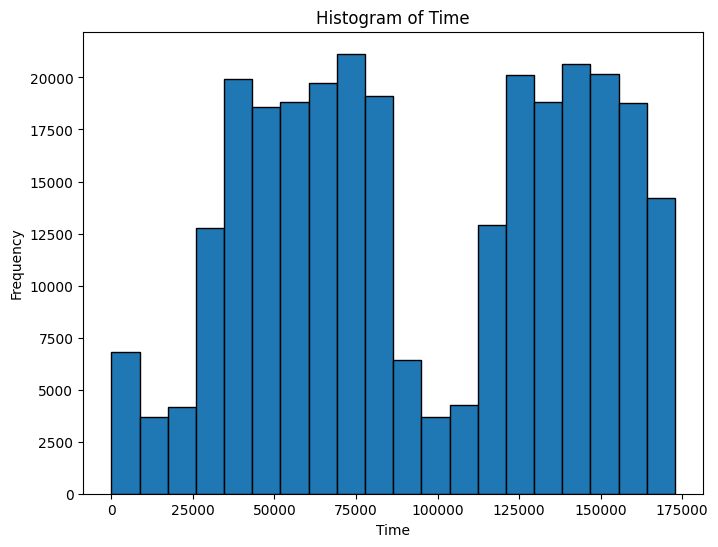

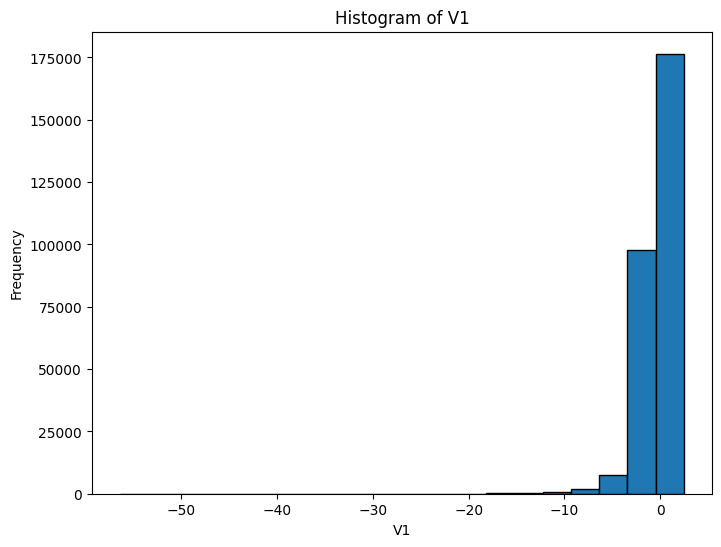

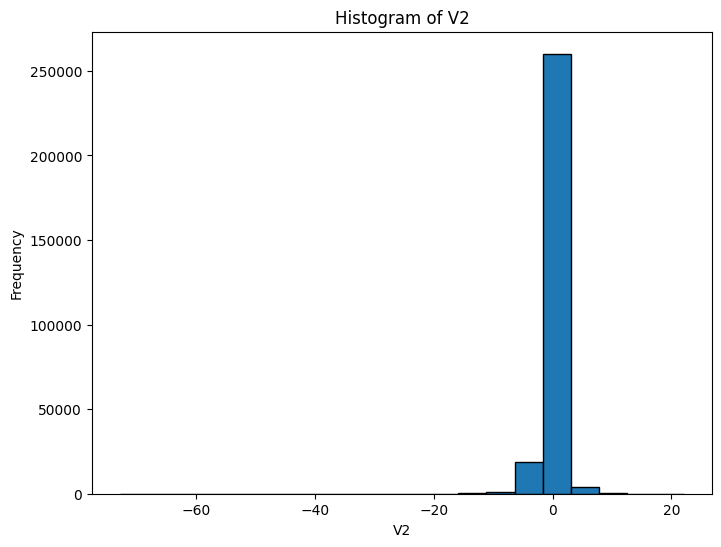

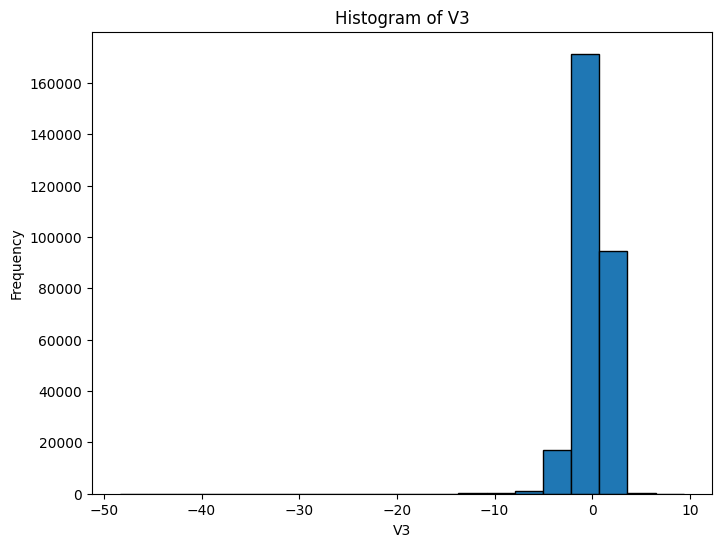

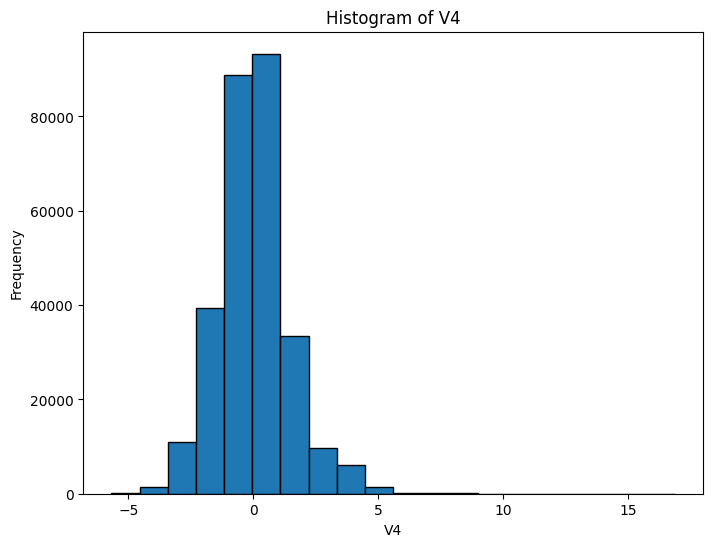

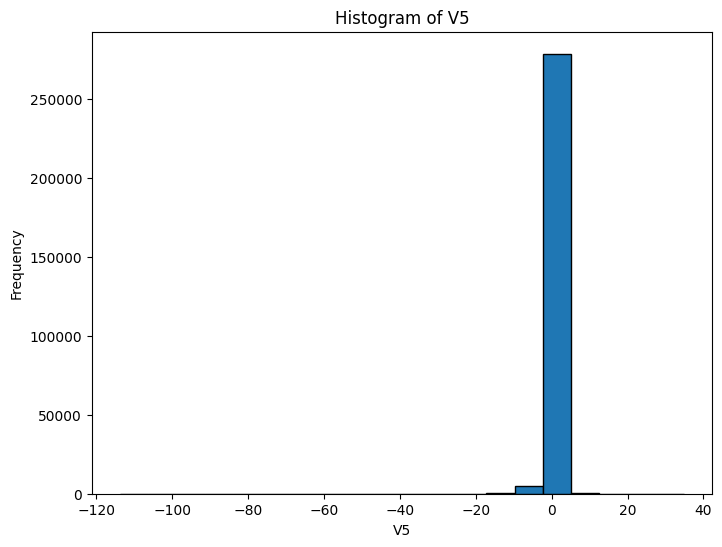

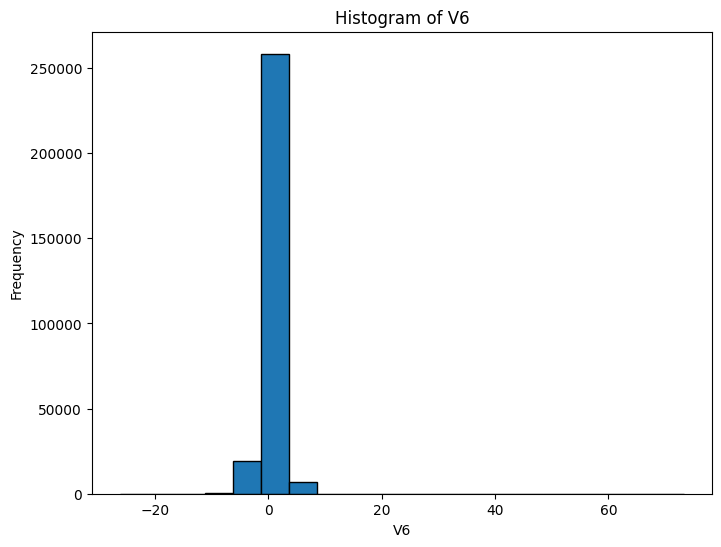

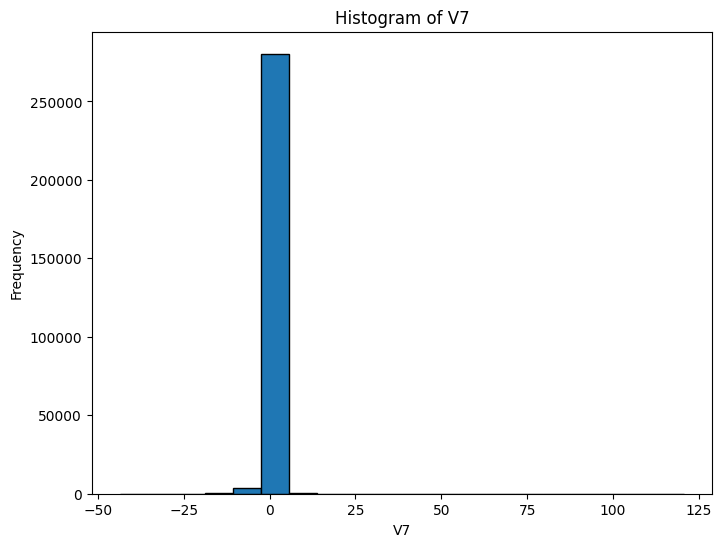

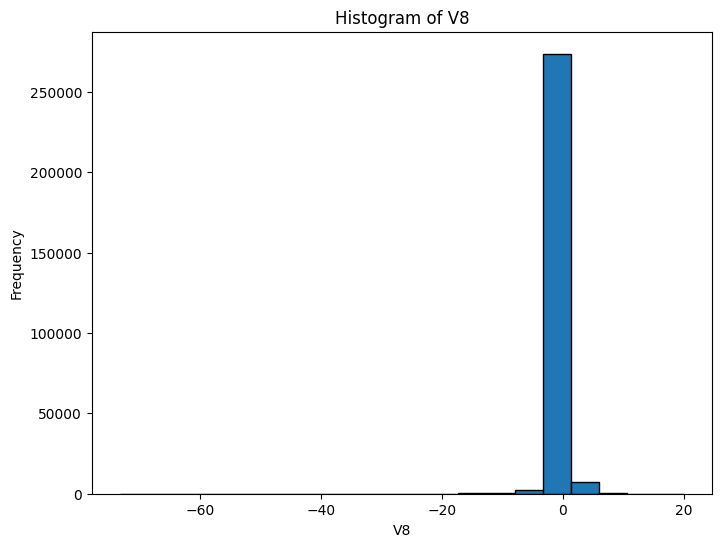

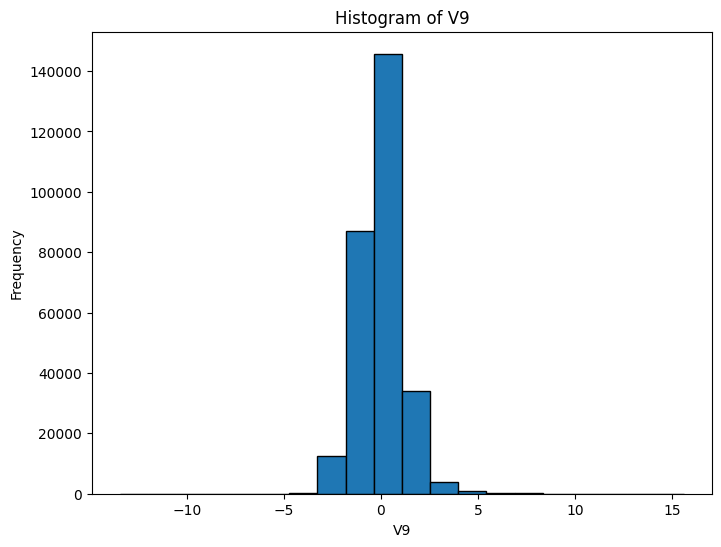

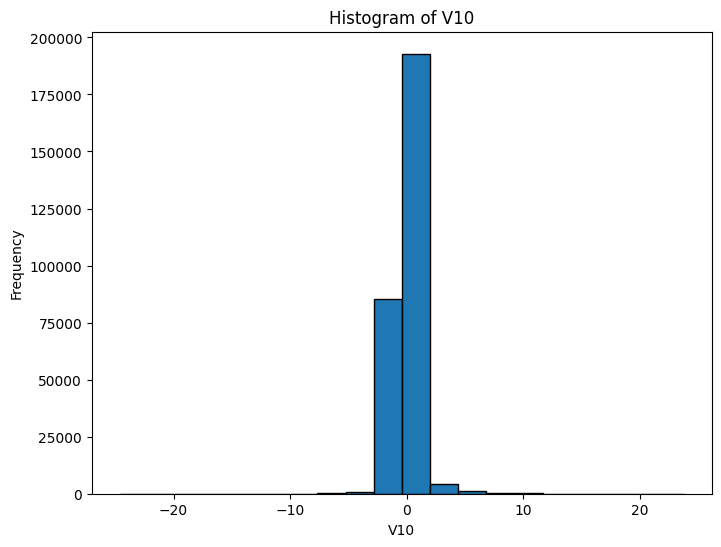

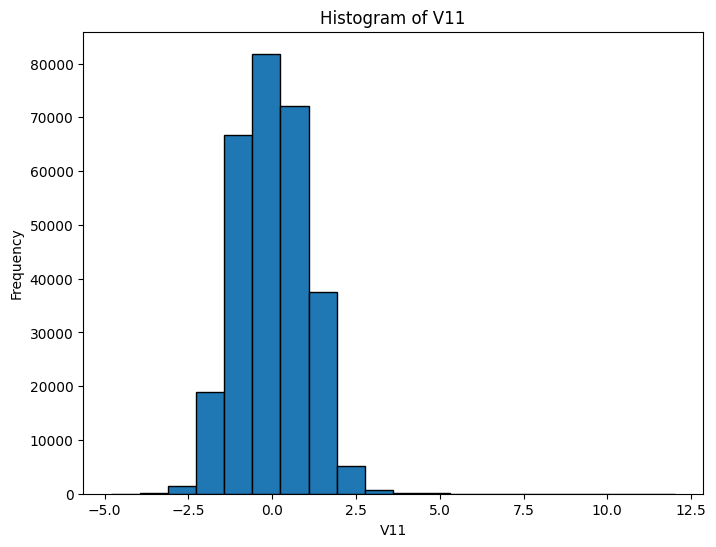

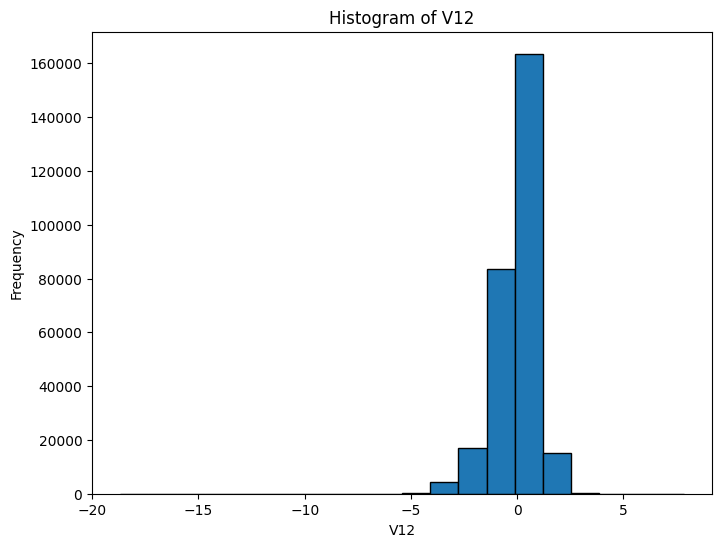

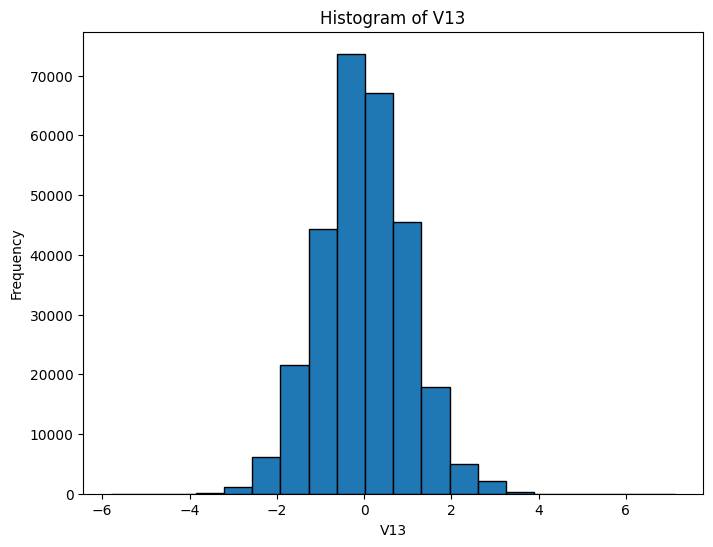

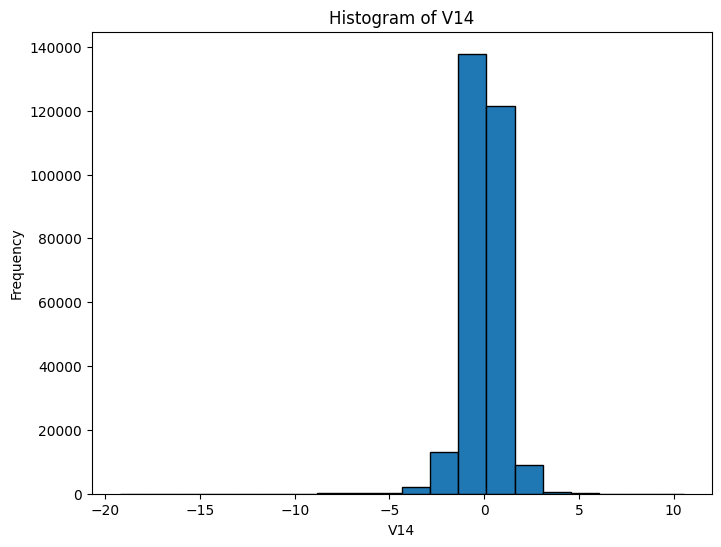

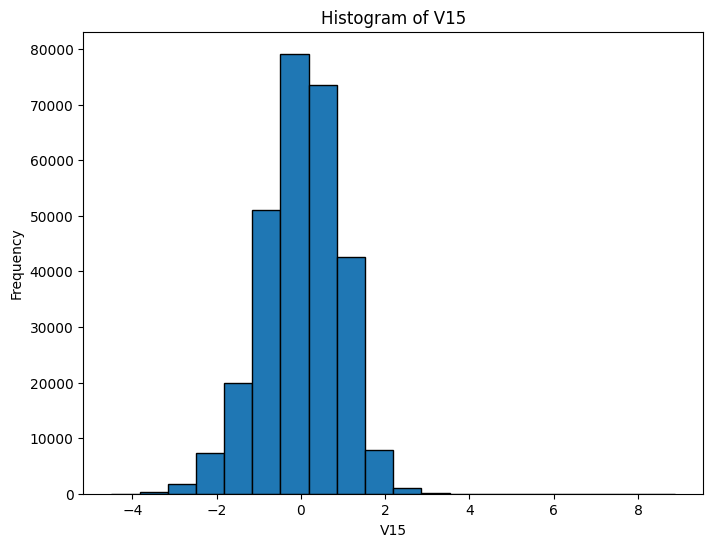

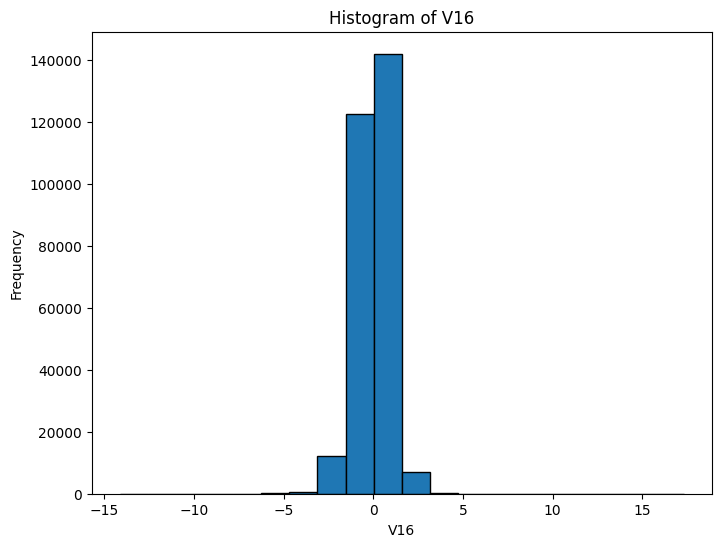

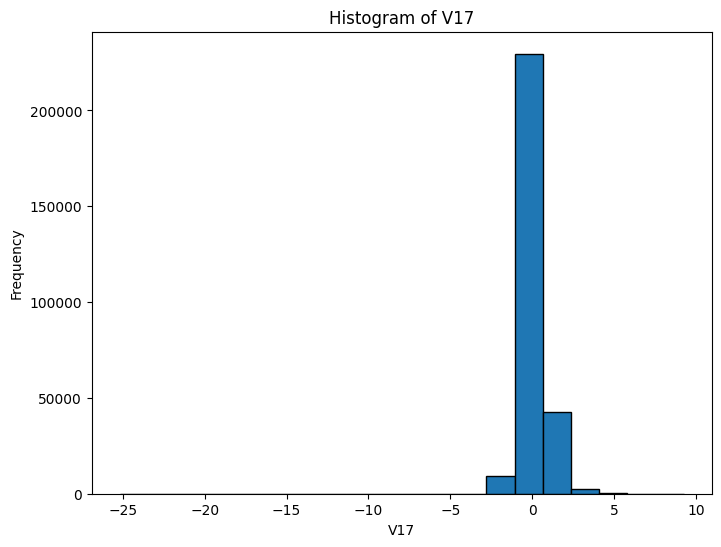

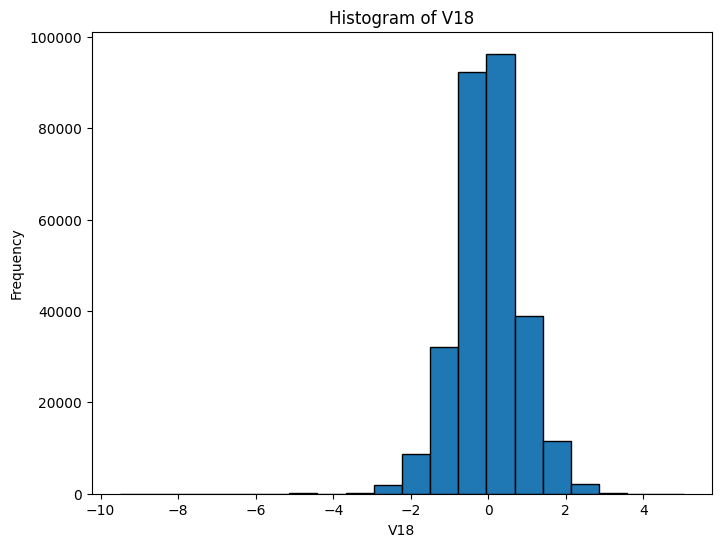

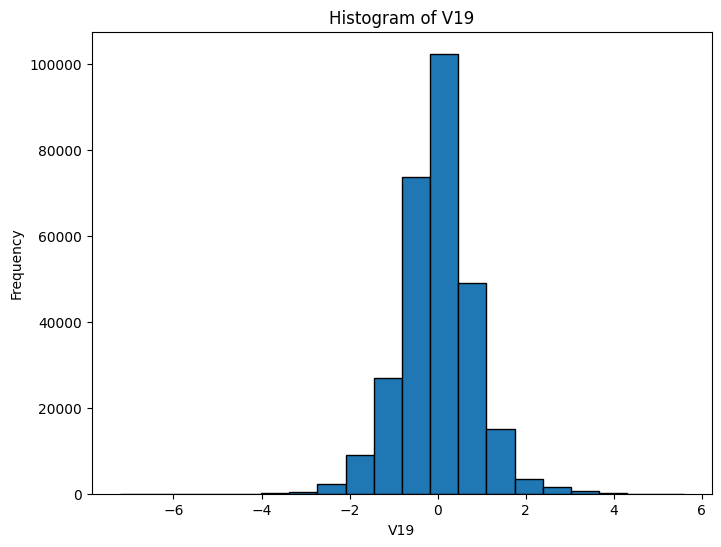

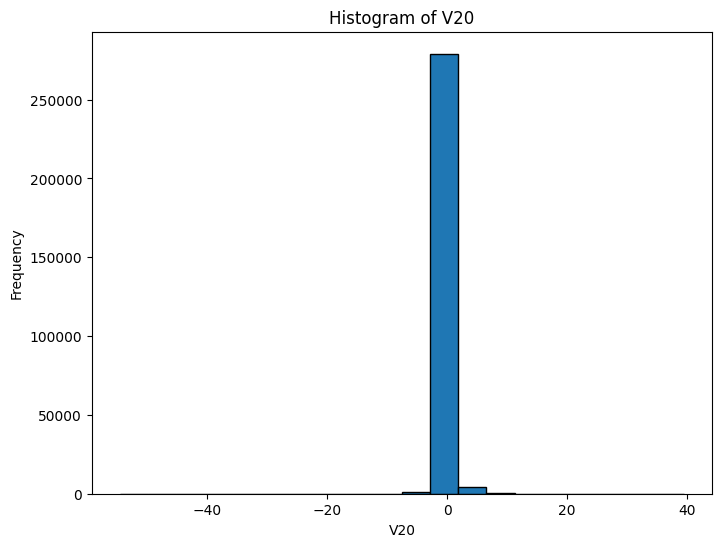

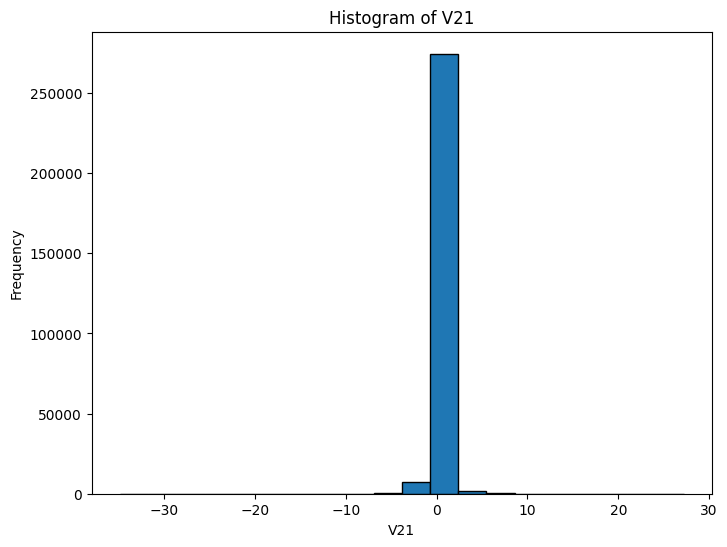

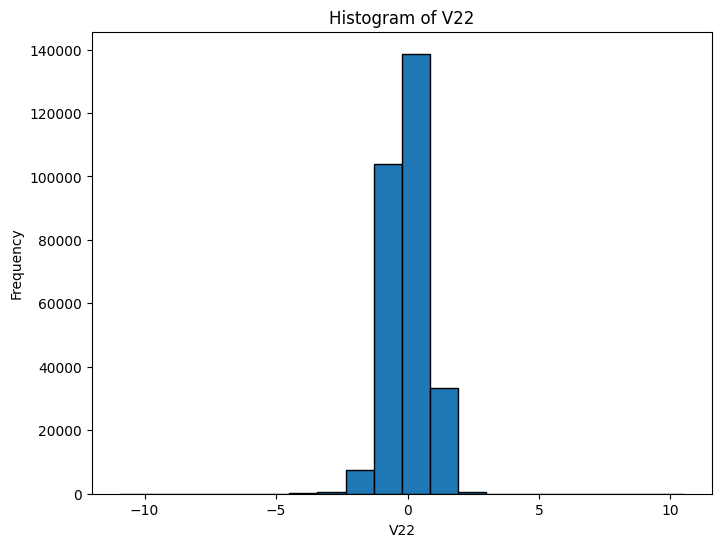

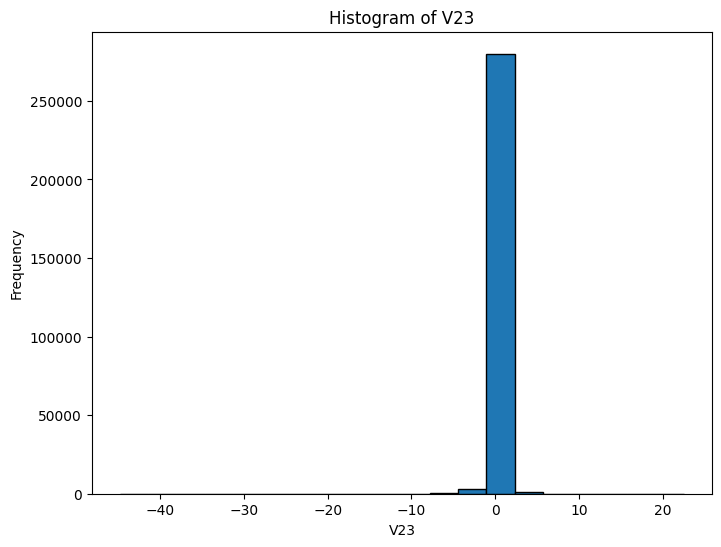

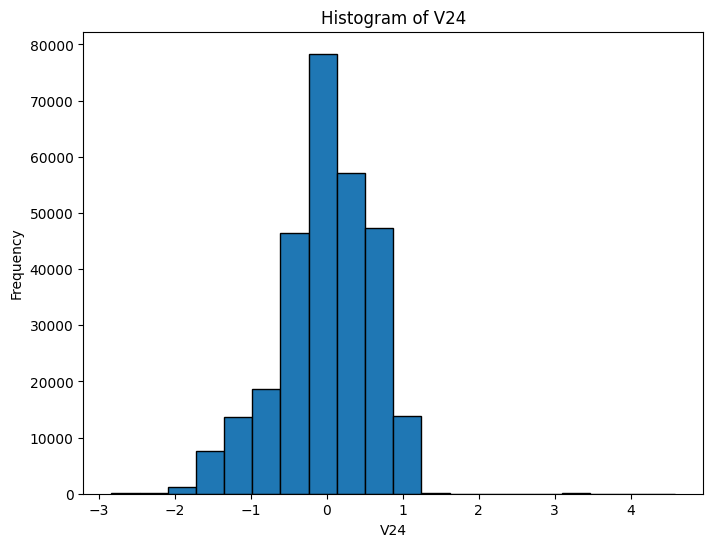

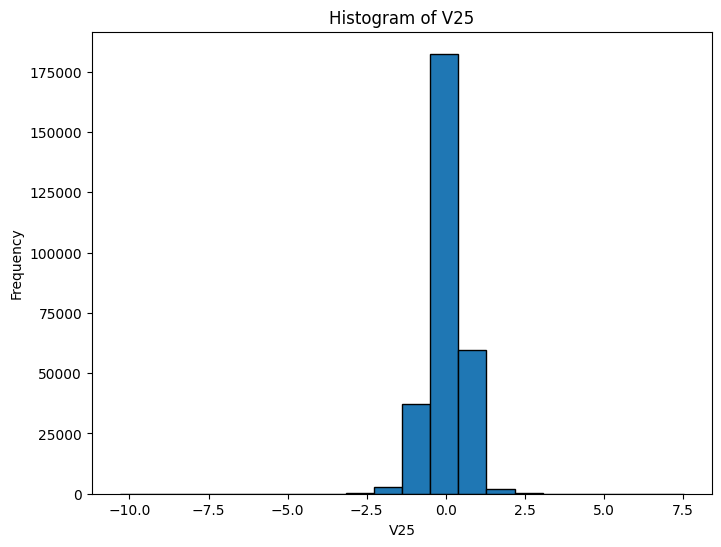

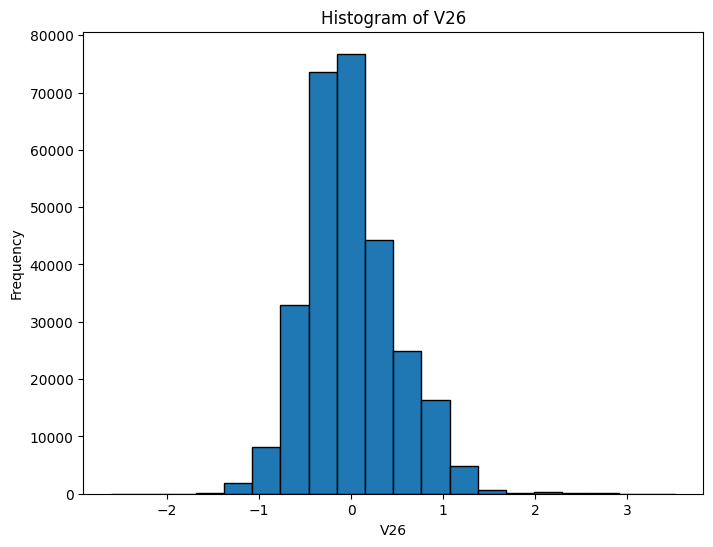

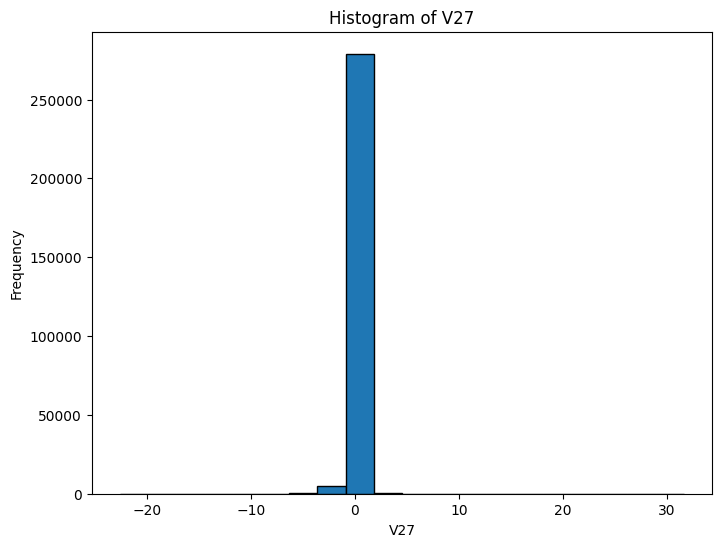

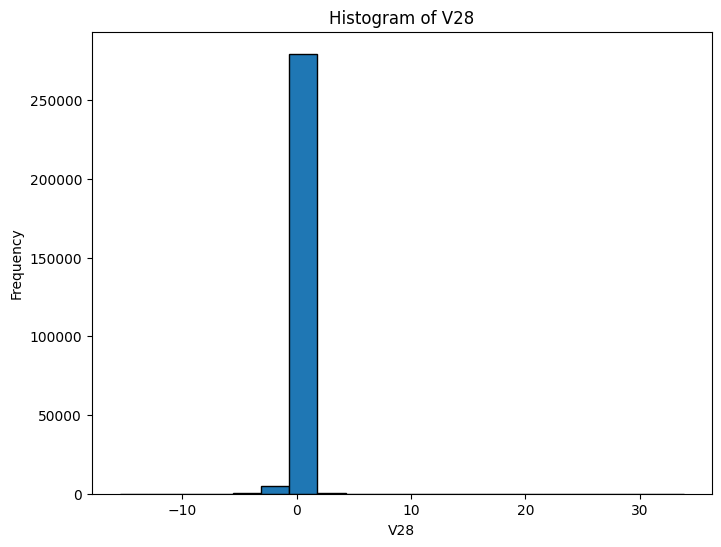

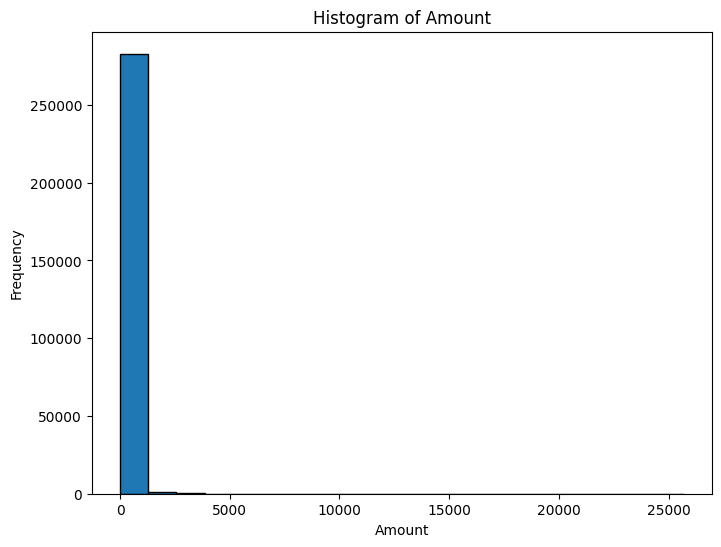

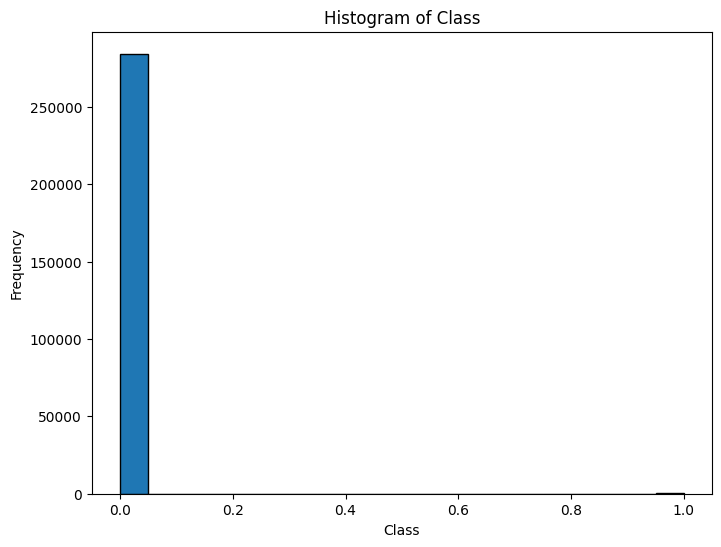

In [18]:
plot_histograms(df)

We see from the above that a few columns show skewness & kurtosis. We may need to correct it before having data modeling & machine learning.

### cross column aggregation

In [19]:
def correlation_analysis(df):
    numeric_columns = [col for col, dtype in df.dtypes if isinstance(df.schema[col].dataType, (T.IntegerType, T.FloatType, T.DoubleType, T.LongType))]
    numeric_columns = [col for col in numeric_columns if col != "class"]  # Exclude "class"

    correlations = {}

    for i in range(len(numeric_columns)):
        for j in range(i+1, len(numeric_columns)):
            col1, col2 = numeric_columns[i], numeric_columns[j]
            corr_value = df.stat.corr(col1, col2)
            correlations[f"{col1}_{col2}_corr"] = corr_value

    return correlations

In [20]:
correlations = correlation_analysis(df)
print("\nCorrelations:")
for cols, corr in correlations.items():
    print(f"{cols}: {corr}")


Correlations:
Time_V1_corr: 0.11739630597838754
Time_V2_corr: -0.010593327121342611
Time_V3_corr: -0.4196181722115263
Time_V4_corr: -0.1052602054457288
Time_V5_corr: 0.17307212331039104
Time_V6_corr: -0.0630164703731505
Time_V7_corr: 0.08471437480498926
Time_V8_corr: -0.03694943469000867
Time_V9_corr: -0.008660433697683878
Time_V10_corr: 0.0306166285923197
Time_V11_corr: -0.24768943748667316
Time_V12_corr: 0.12434806837193191
Time_V13_corr: -0.06590202369761679
Time_V14_corr: -0.09875681920622545
Time_V15_corr: -0.18345327348103443
Time_V16_corr: 0.011902867722434039
Time_V17_corr: -0.0732972133177973
Time_V18_corr: 0.09043813254861033
Time_V19_corr: 0.02897530256113444
Time_V20_corr: -0.050866018468353806
Time_V21_corr: 0.044735726289081054
Time_V22_corr: 0.14405905486146367
Time_V23_corr: 0.051142364941773
Time_V24_corr: -0.016181868459307455
Time_V25_corr: -0.23308279059831166
Time_V26_corr: -0.04140710060605824
Time_V27_corr: -0.00513459112399719
Time_V28_corr: -0.0094126881790523

In [ ]:
# skip this step for time saving
# results are similar to corr
# Plotting pairwise relationships for numeric columns
# def plot_pairwise(df):
#     numeric_columns = [col for col, dtype in df.dtypes if isinstance(df.schema[col].dataType, (T.IntegerType, T.FloatType, T.DoubleType, T.LongType))]

#     # Pairwise relationships (scatter plots) between numeric columns
#     for i in range(len(numeric_columns)):
#         for j in range(i+1, len(numeric_columns)):
#             col1, col2 = numeric_columns[i], numeric_columns[j]
#             data1 = df.select(col1).rdd.flatMap(lambda x: x).collect()
#             data2 = df.select(col2).rdd.flatMap(lambda x: x).collect()
#             plt.figure(figsize=(8, 6))
#             plt.scatter(data1, data2, alpha=0.5)
#             plt.title(f"Scatter Plot between {col1} and {col2}")
#             plt.xlabel(col1)
#             plt.ylabel(col2)
#             plt.show()

## anomaly detection

In [21]:
# Function to calculate Q1, Q3, IQR, and detect outliers
def detect_anomalies(df, column):
    # Calculate Q1, Q3, and IQR for the given column
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Detect outliers based on IQR
    outliers = df.filter((F.col(column) < lower_bound) | (F.col(column) > upper_bound))
    print(f"Column name: {column}")
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    print(f"Number of outliers in {column}: {outliers.count()}")

In [22]:
cols = [col for col, dtype in df.dtypes if isinstance(df.schema[col].dataType, (T.IntegerType, T.FloatType, T.DoubleType, T.LongType))]
for col in cols:
  detect_anomalies(df, col)

Column name: Time
Lower Bound: -66588.0, Upper Bound: 254140.0
Number of outliers in Time: 0
Column name: V1
Lower Bound: -4.384571703813029, Upper Bound: 4.61850754419777
Number of outliers in V1: 6716
Column name: V2
Lower Bound: -2.5740562638304603, Upper Bound: 2.624017932509028
Number of outliers in V2: 15460
Column name: V3
Lower Bound: -3.740999603006573, Upper Bound: 3.68981534659095
Number of outliers in V3: 3500
Column name: V4
Lower Bound: -3.233232888502543, Upper Bound: 2.911675764663513
Number of outliers in V4: 12722
Column name: V5
Lower Bound: -2.51369506313019, Upper Bound: 2.2961097048185737
Number of outliers in V5: 15836
Column name: V6
Lower Bound: -2.38512473608552, Upper Bound: 1.859639064876216
Number of outliers in V6: 25757
Column name: V7
Lower Bound: -2.1892060251324503, Upper Bound: 2.0970291484243218
Number of outliers in V7: 9930
Column name: V8
Lower Bound: -0.9071281060136516, Upper Bound: 0.9576294494136806
Number of outliers in V8: 31009
Column name:

In [23]:
# Function to plot boxplot for anomaly detection
def plot_boxplot(df, column):
    # Convert the column to an RDD and collect data for plotting
    data = df.select(column).rdd.flatMap(lambda x: x).collect()

    # Create a boxplot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data)
    plt.title(f"Boxplot for {column}")
    plt.xlabel(column)
    plt.show()

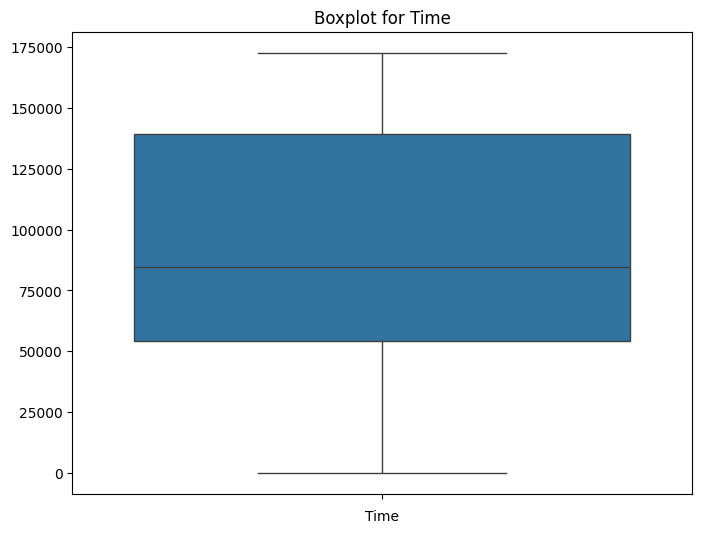

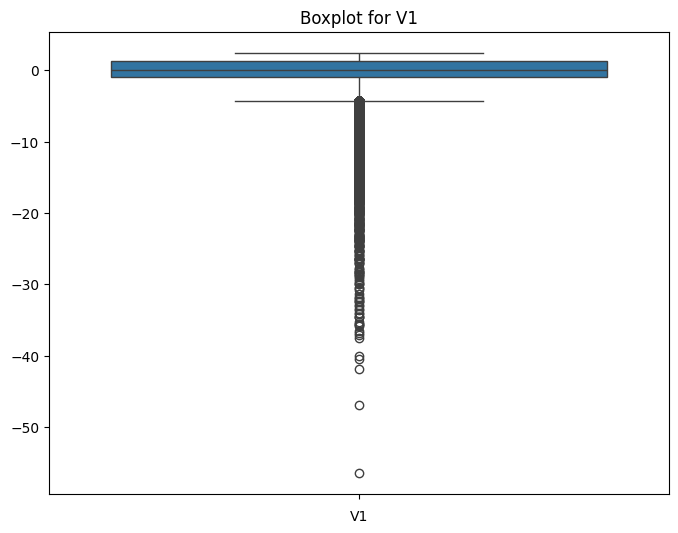

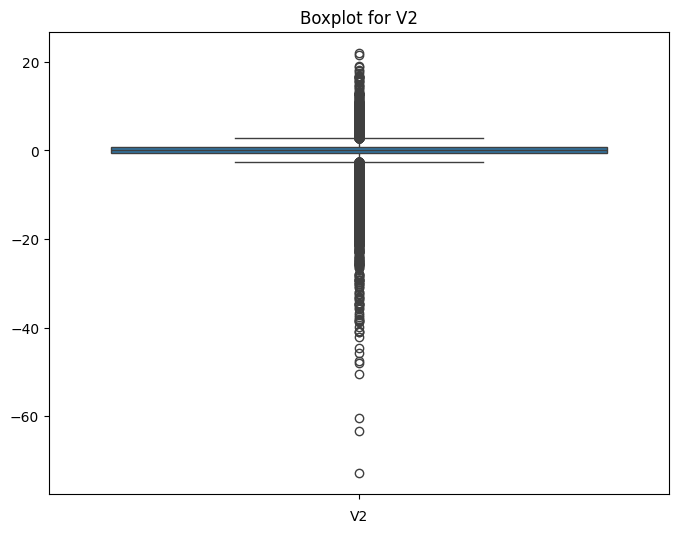

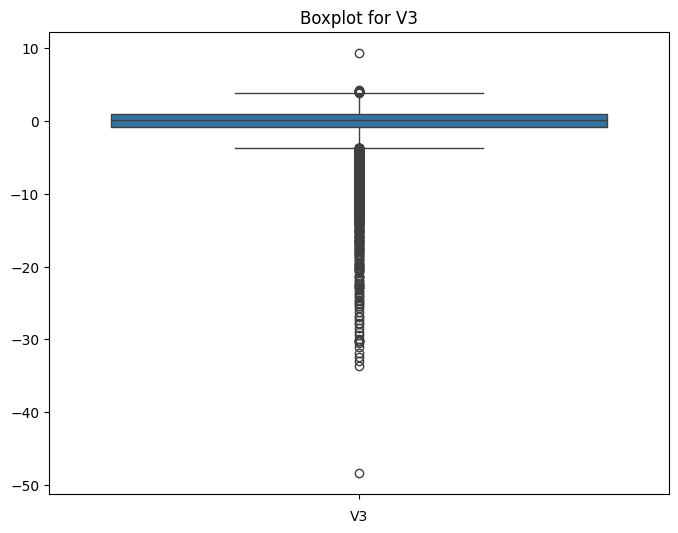

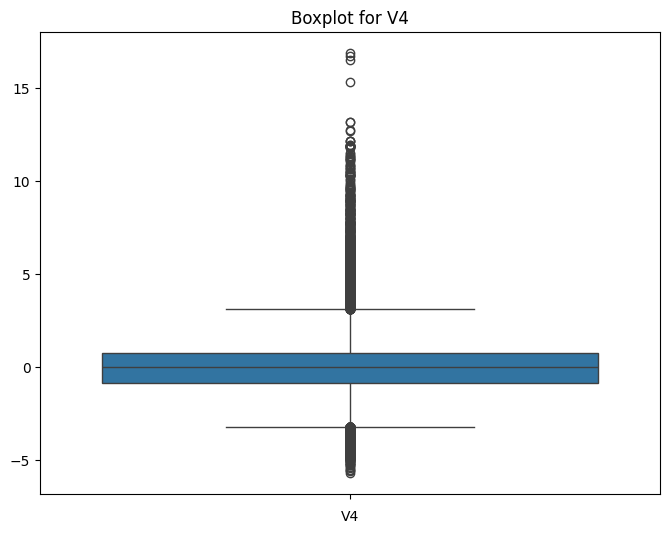

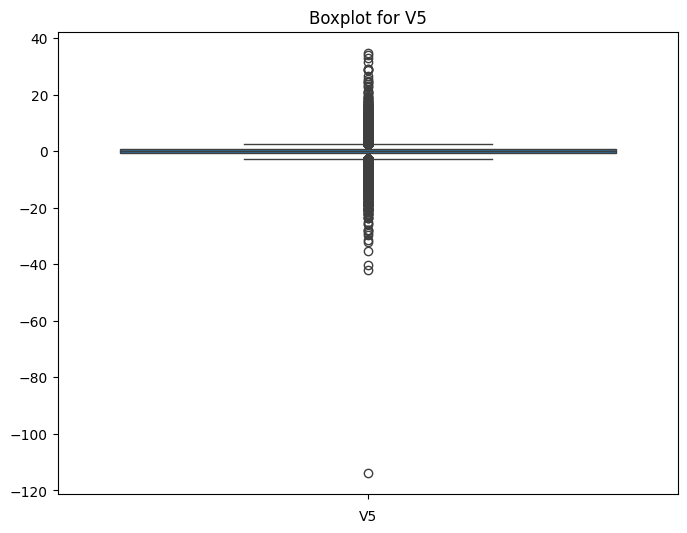

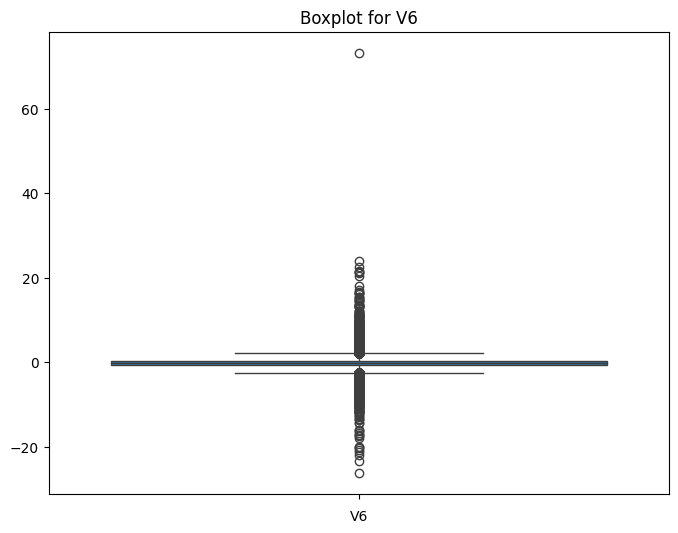

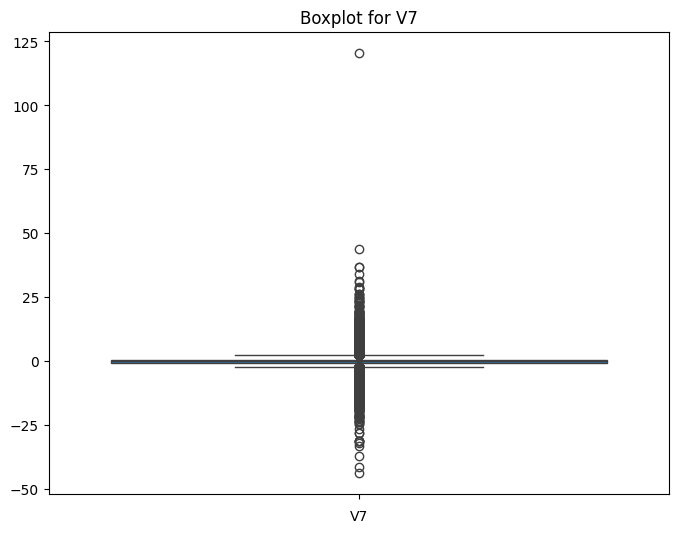

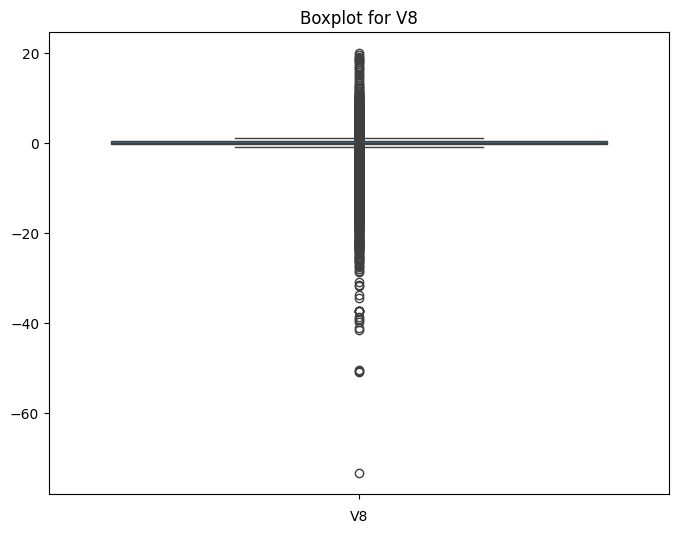

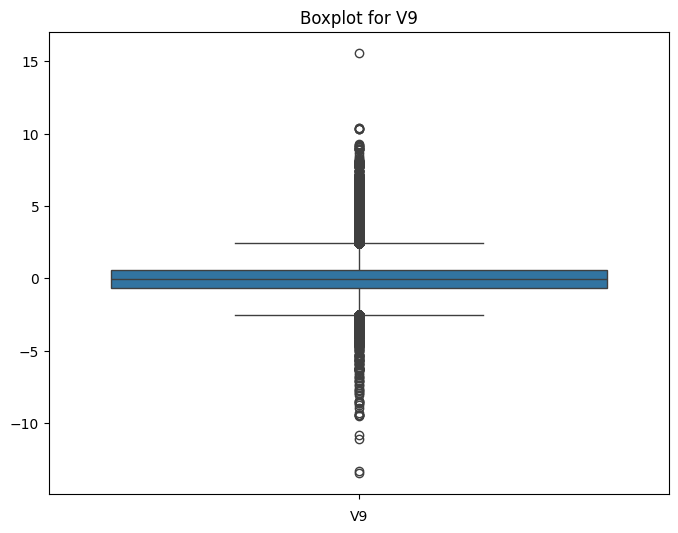

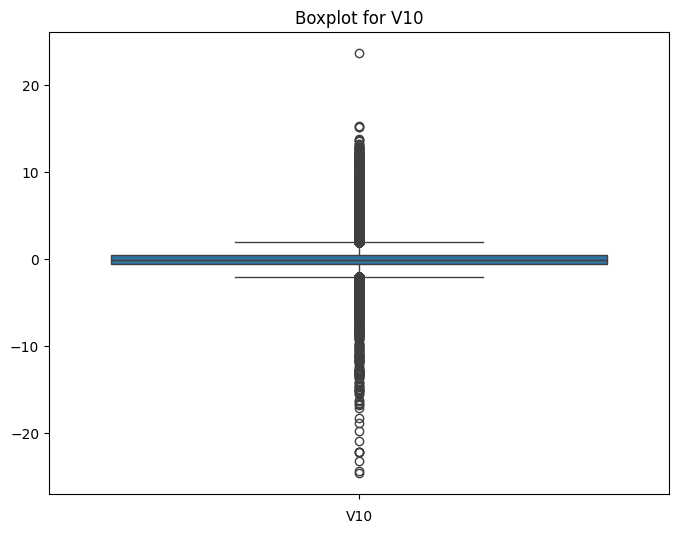

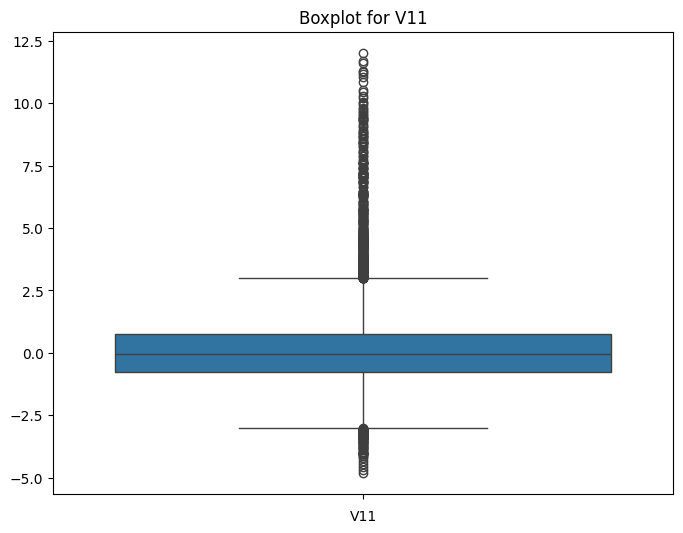

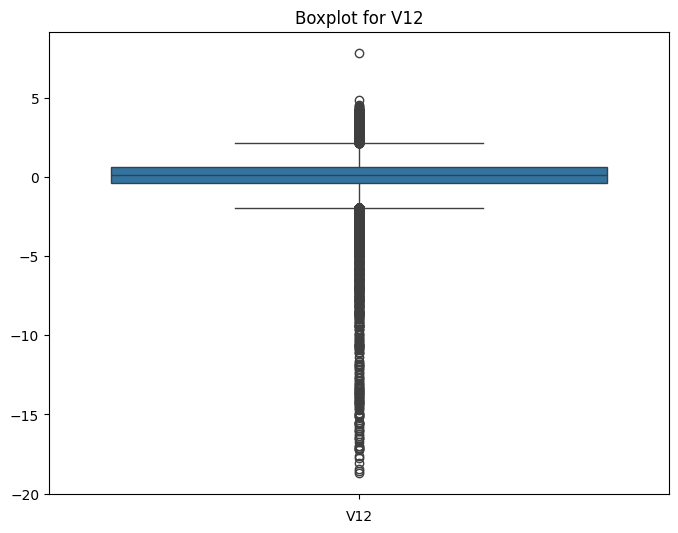

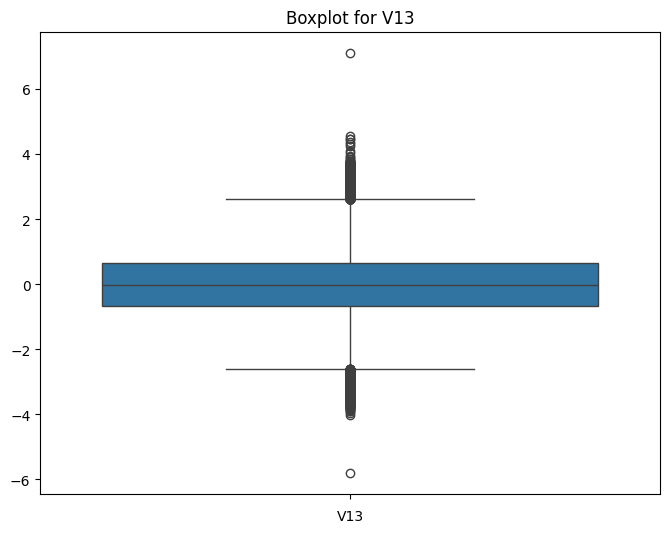

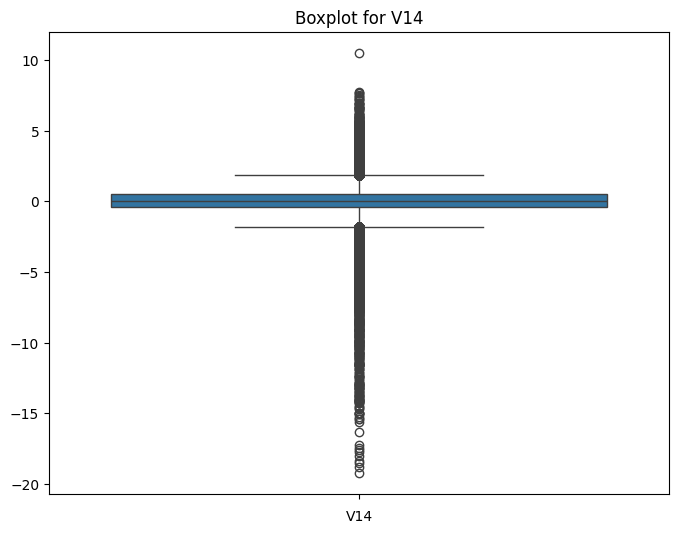

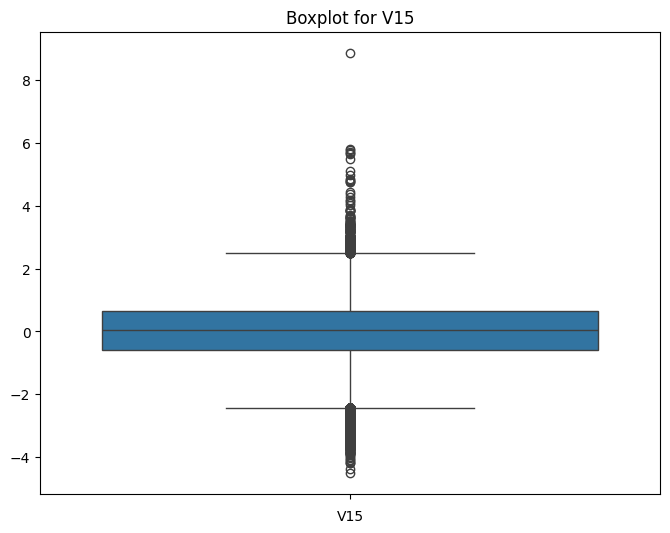

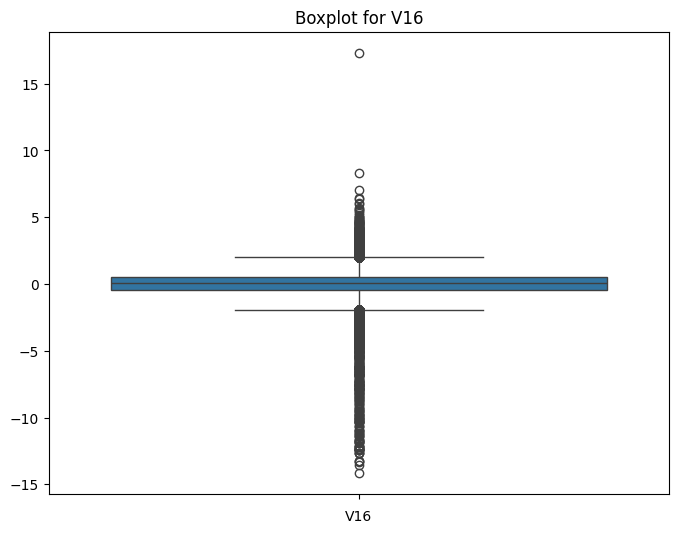

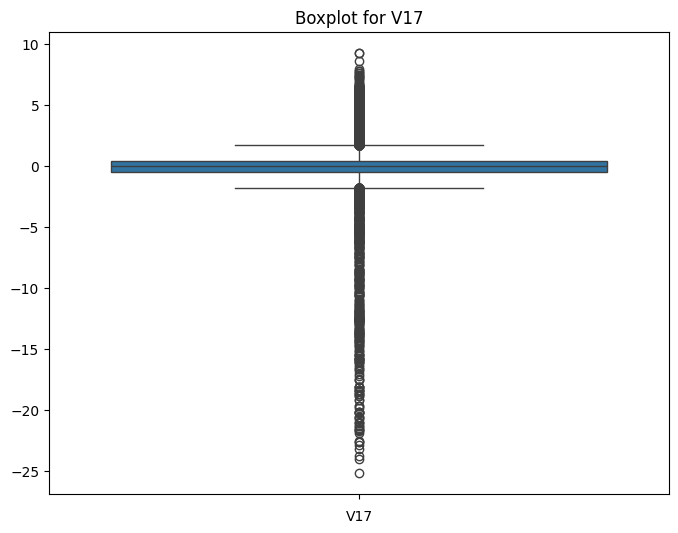

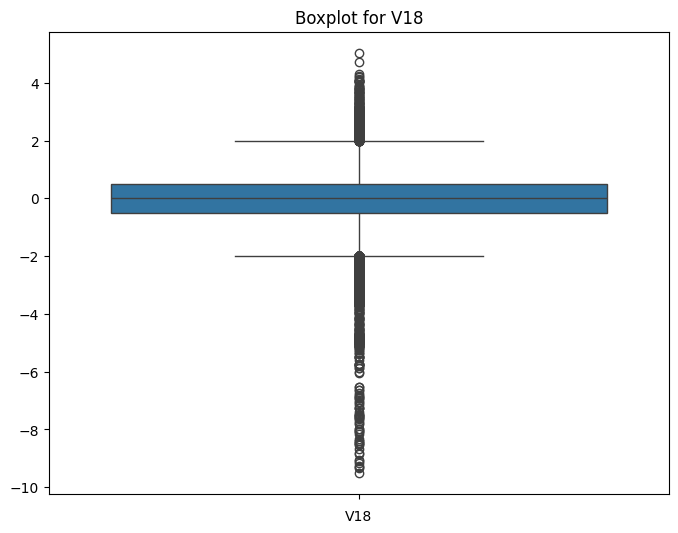

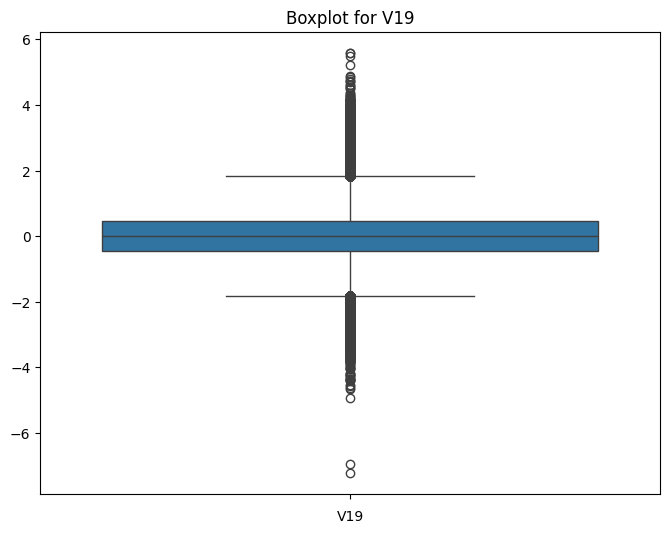

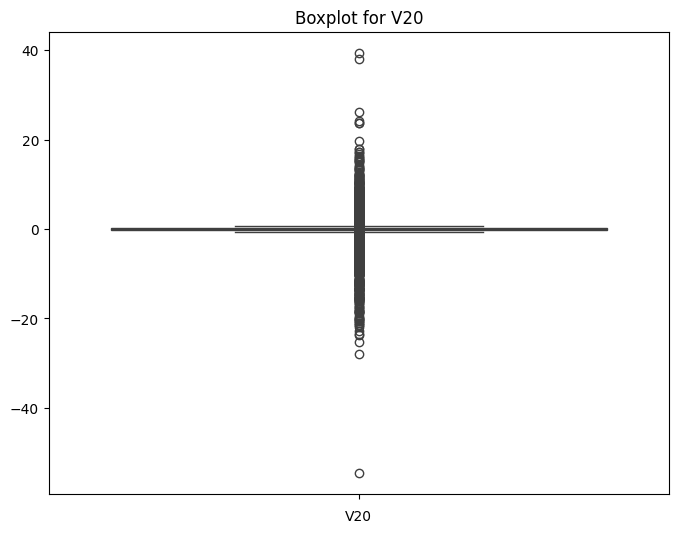

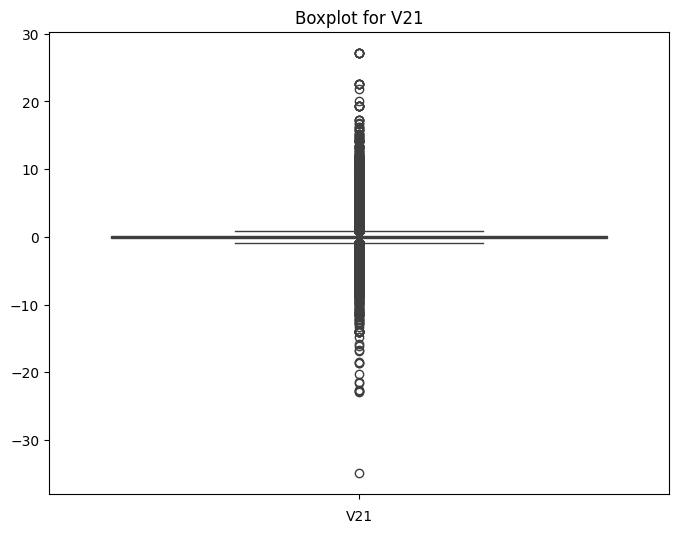

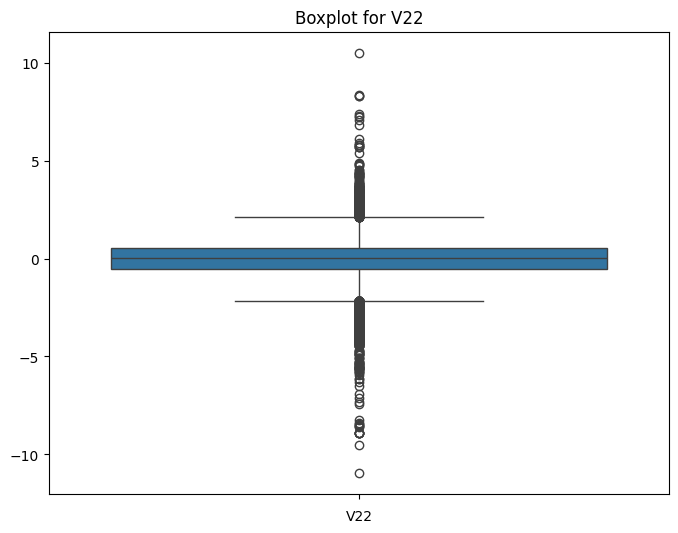

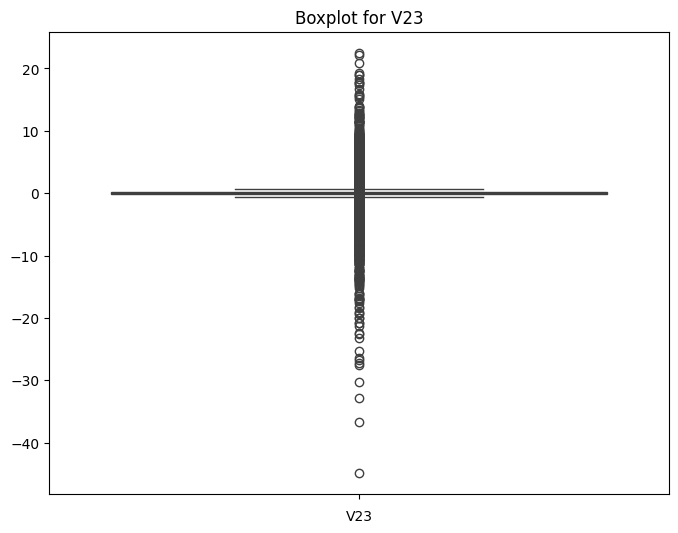

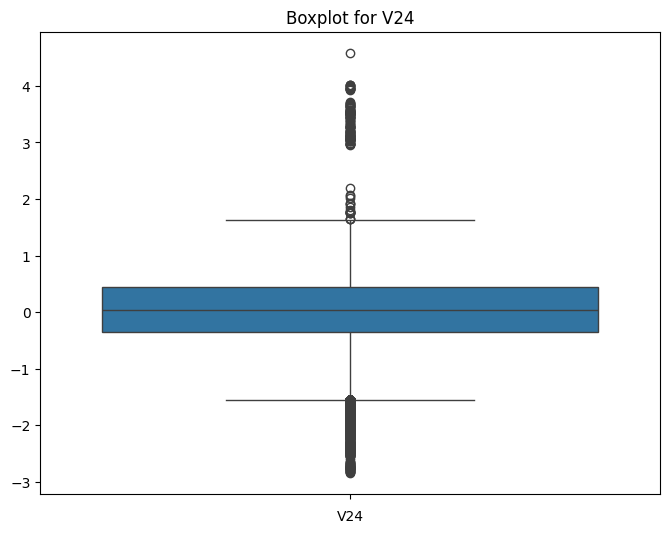

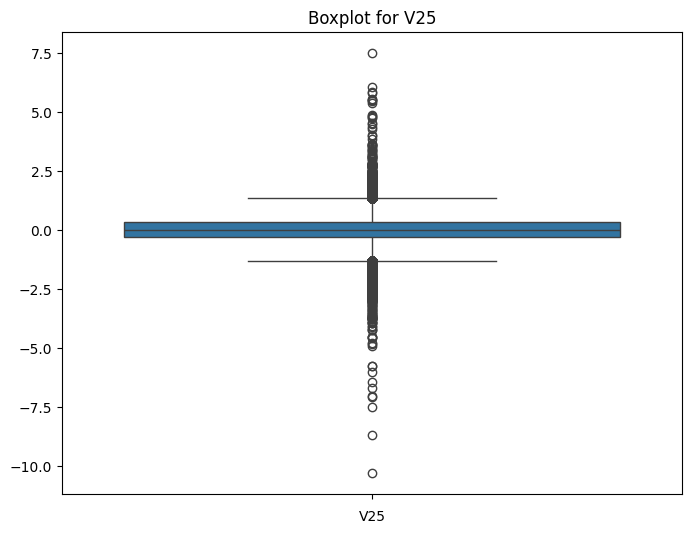

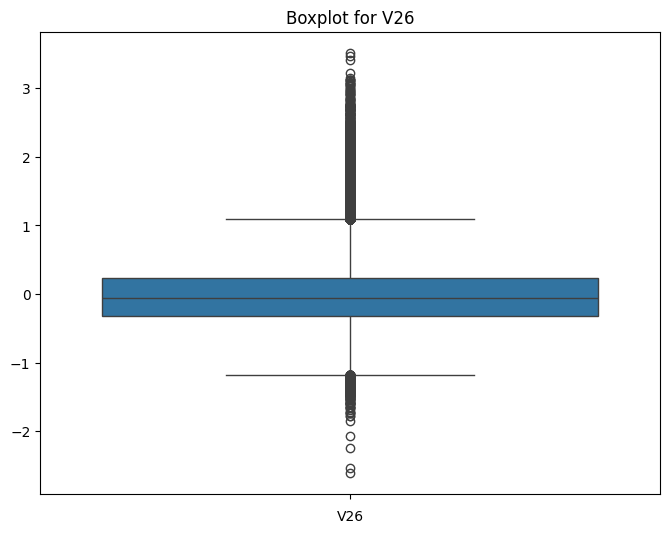

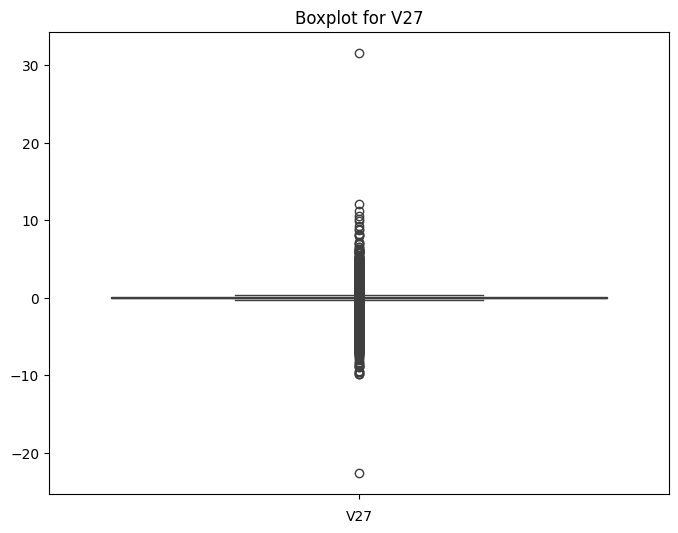

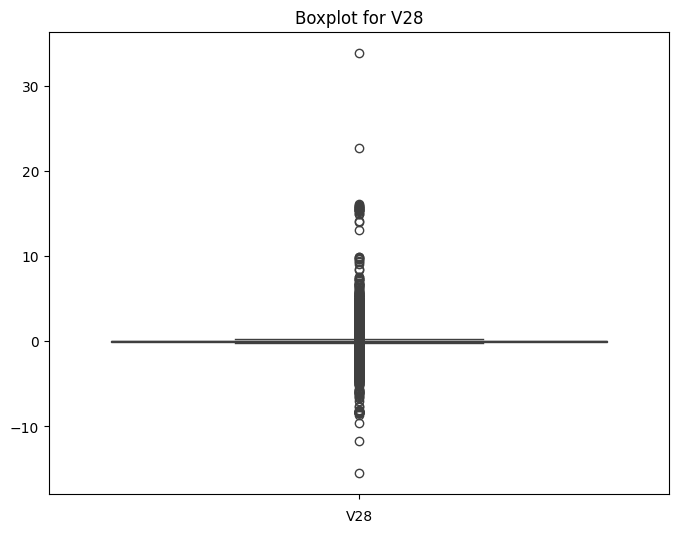

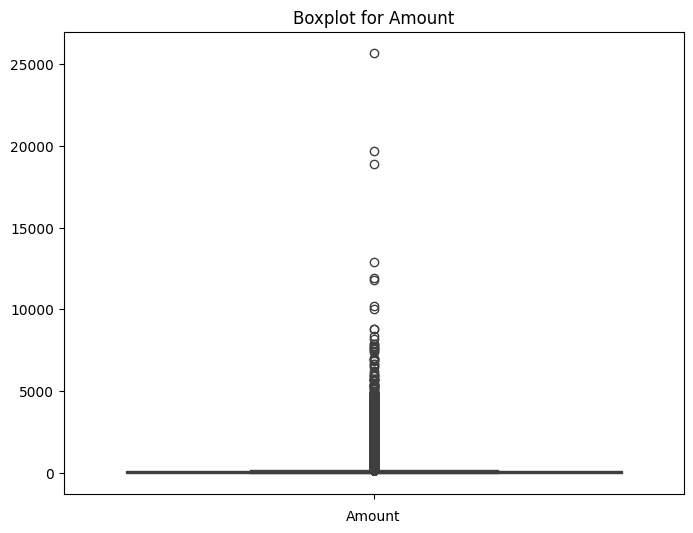

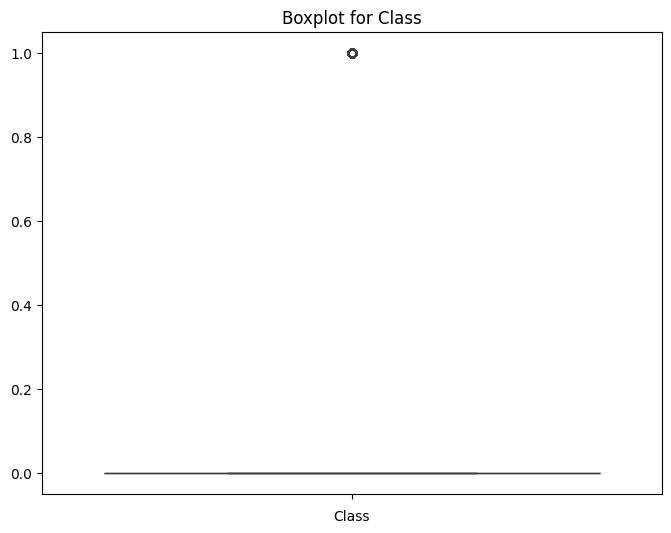

In [24]:
for col in cols:
  plot_boxplot(df, col)

## close session

In [25]:
spark.stop()